# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.306997,True,5.706136
1,1.630734,True,9.358802
2,0.559030,False,1.047554
3,1.515037,False,4.069826
4,0.735085,True,8.443400
...,...,...,...
995,0.703817,True,6.872143
996,0.785805,True,8.544829
997,2.107539,True,12.385694
998,0.523446,True,7.775213


<AxesSubplot:xlabel='v0'>

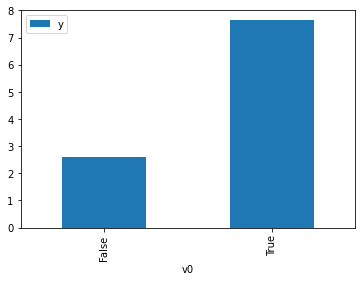

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

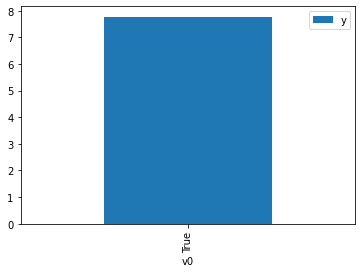

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.607081,False,6.404911,0.449612,2.224141
1,0.888944,False,1.787793,0.473374,2.112495
2,-0.450483,False,-0.390594,0.491988,2.032570
3,1.085846,False,2.404779,0.470643,2.124755
4,0.681040,False,1.832274,0.476260,2.099695
...,...,...,...,...,...
995,1.776587,False,6.000066,0.461076,2.168841
996,2.016825,False,5.242795,0.457755,2.184576
997,-0.251294,False,-1.037672,0.489217,2.044082
998,-0.129405,False,-0.683385,0.487522,2.051189


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.818505,True,6.664785,0.525649,1.902412
1,-0.940454,True,1.029534,0.501195,1.995233
2,-1.755966,True,0.765128,0.489848,2.041450
3,2.152420,True,11.827785,0.544118,1.837837
4,0.970638,True,8.463239,0.527760,1.894802
...,...,...,...,...,...
995,1.935231,True,8.877541,0.541118,1.848027
996,1.174251,True,8.020753,0.530583,1.884718
997,1.523967,True,8.445390,0.535428,1.867663
998,2.217313,True,11.321477,0.545014,1.834816


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          1.994e+04
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:55:27   Log-Likelihood:                         -1452.1
No. Observations:                1000   AIC:                                      2908.
Df Residuals:                     998   BIC:                                      2918.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7043      0.027    100.502      0.000       2.652       2.757
x2             5.0199      0.053     95.257      0.000       4.917       5.123
==============================================================================
Omnibus:                        2.923   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.769
Skew:                           0.077   Prob(JB):                        0.250
Kurtosis:                       2.794   Cond. No.                         2.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""